测试约束

In [24]:
# essentially import the `Main` module of Julia
from juliacall import Main as jl
import juliapkg
import numpy as np
import csv
import pandas as pd

Read tasks from jld2

In [94]:
tasks = np.genfromtxt('data/vehicle_data_200.csv', delimiter=',', names=True, dtype=None, encoding='ANSI')
phase_base_load = np.genfromtxt('data/phase_base_load.csv', delimiter=',', dtype=None, encoding='UTF-8')

Read model.x for file

In [95]:
with open('./data/optimization5.csv', 'r') as csv_file:
    data = csv.DictReader(csv_file)
    print(data.fieldnames)
    model_x = []
    for row in data:
        value = row['Value']
        model_x.append(value)

['Key', 'Lower', 'Value', 'Upper', 'Fixed', 'Stale', 'Domain']


Change to a 100 * 96 two-dimensional matrix

In [96]:
model_x = np.array(model_x).reshape((200, 96))
print(model_x)

[['0' '0' '0' ... '0' '0' '0']
 ['0' '0' '0' ... '0' '0' '0']
 ['0' '0' '0' ... '1' '0' '0']
 ...
 ['0' '0' '0' ... '0' '0' '0']
 ['0' '0' '0' ... '0' '0' '0']
 ['0' '0' '0' ... '0' '0' '0']]


Get base load and restriction

In [97]:
base_load = np.sum(phase_base_load, axis = 0)
restriction_in_power = 2200 - base_load
print(base_load.shape)

(96,)


Plot the circuit load restriction

In [98]:
model_x = model_x.astype(np.float64)
power = np.expand_dims(tasks['P'], axis=1)
power_list = power * model_x
used_power = np.sum(power_list, axis = 0)
total_power = base_load + used_power

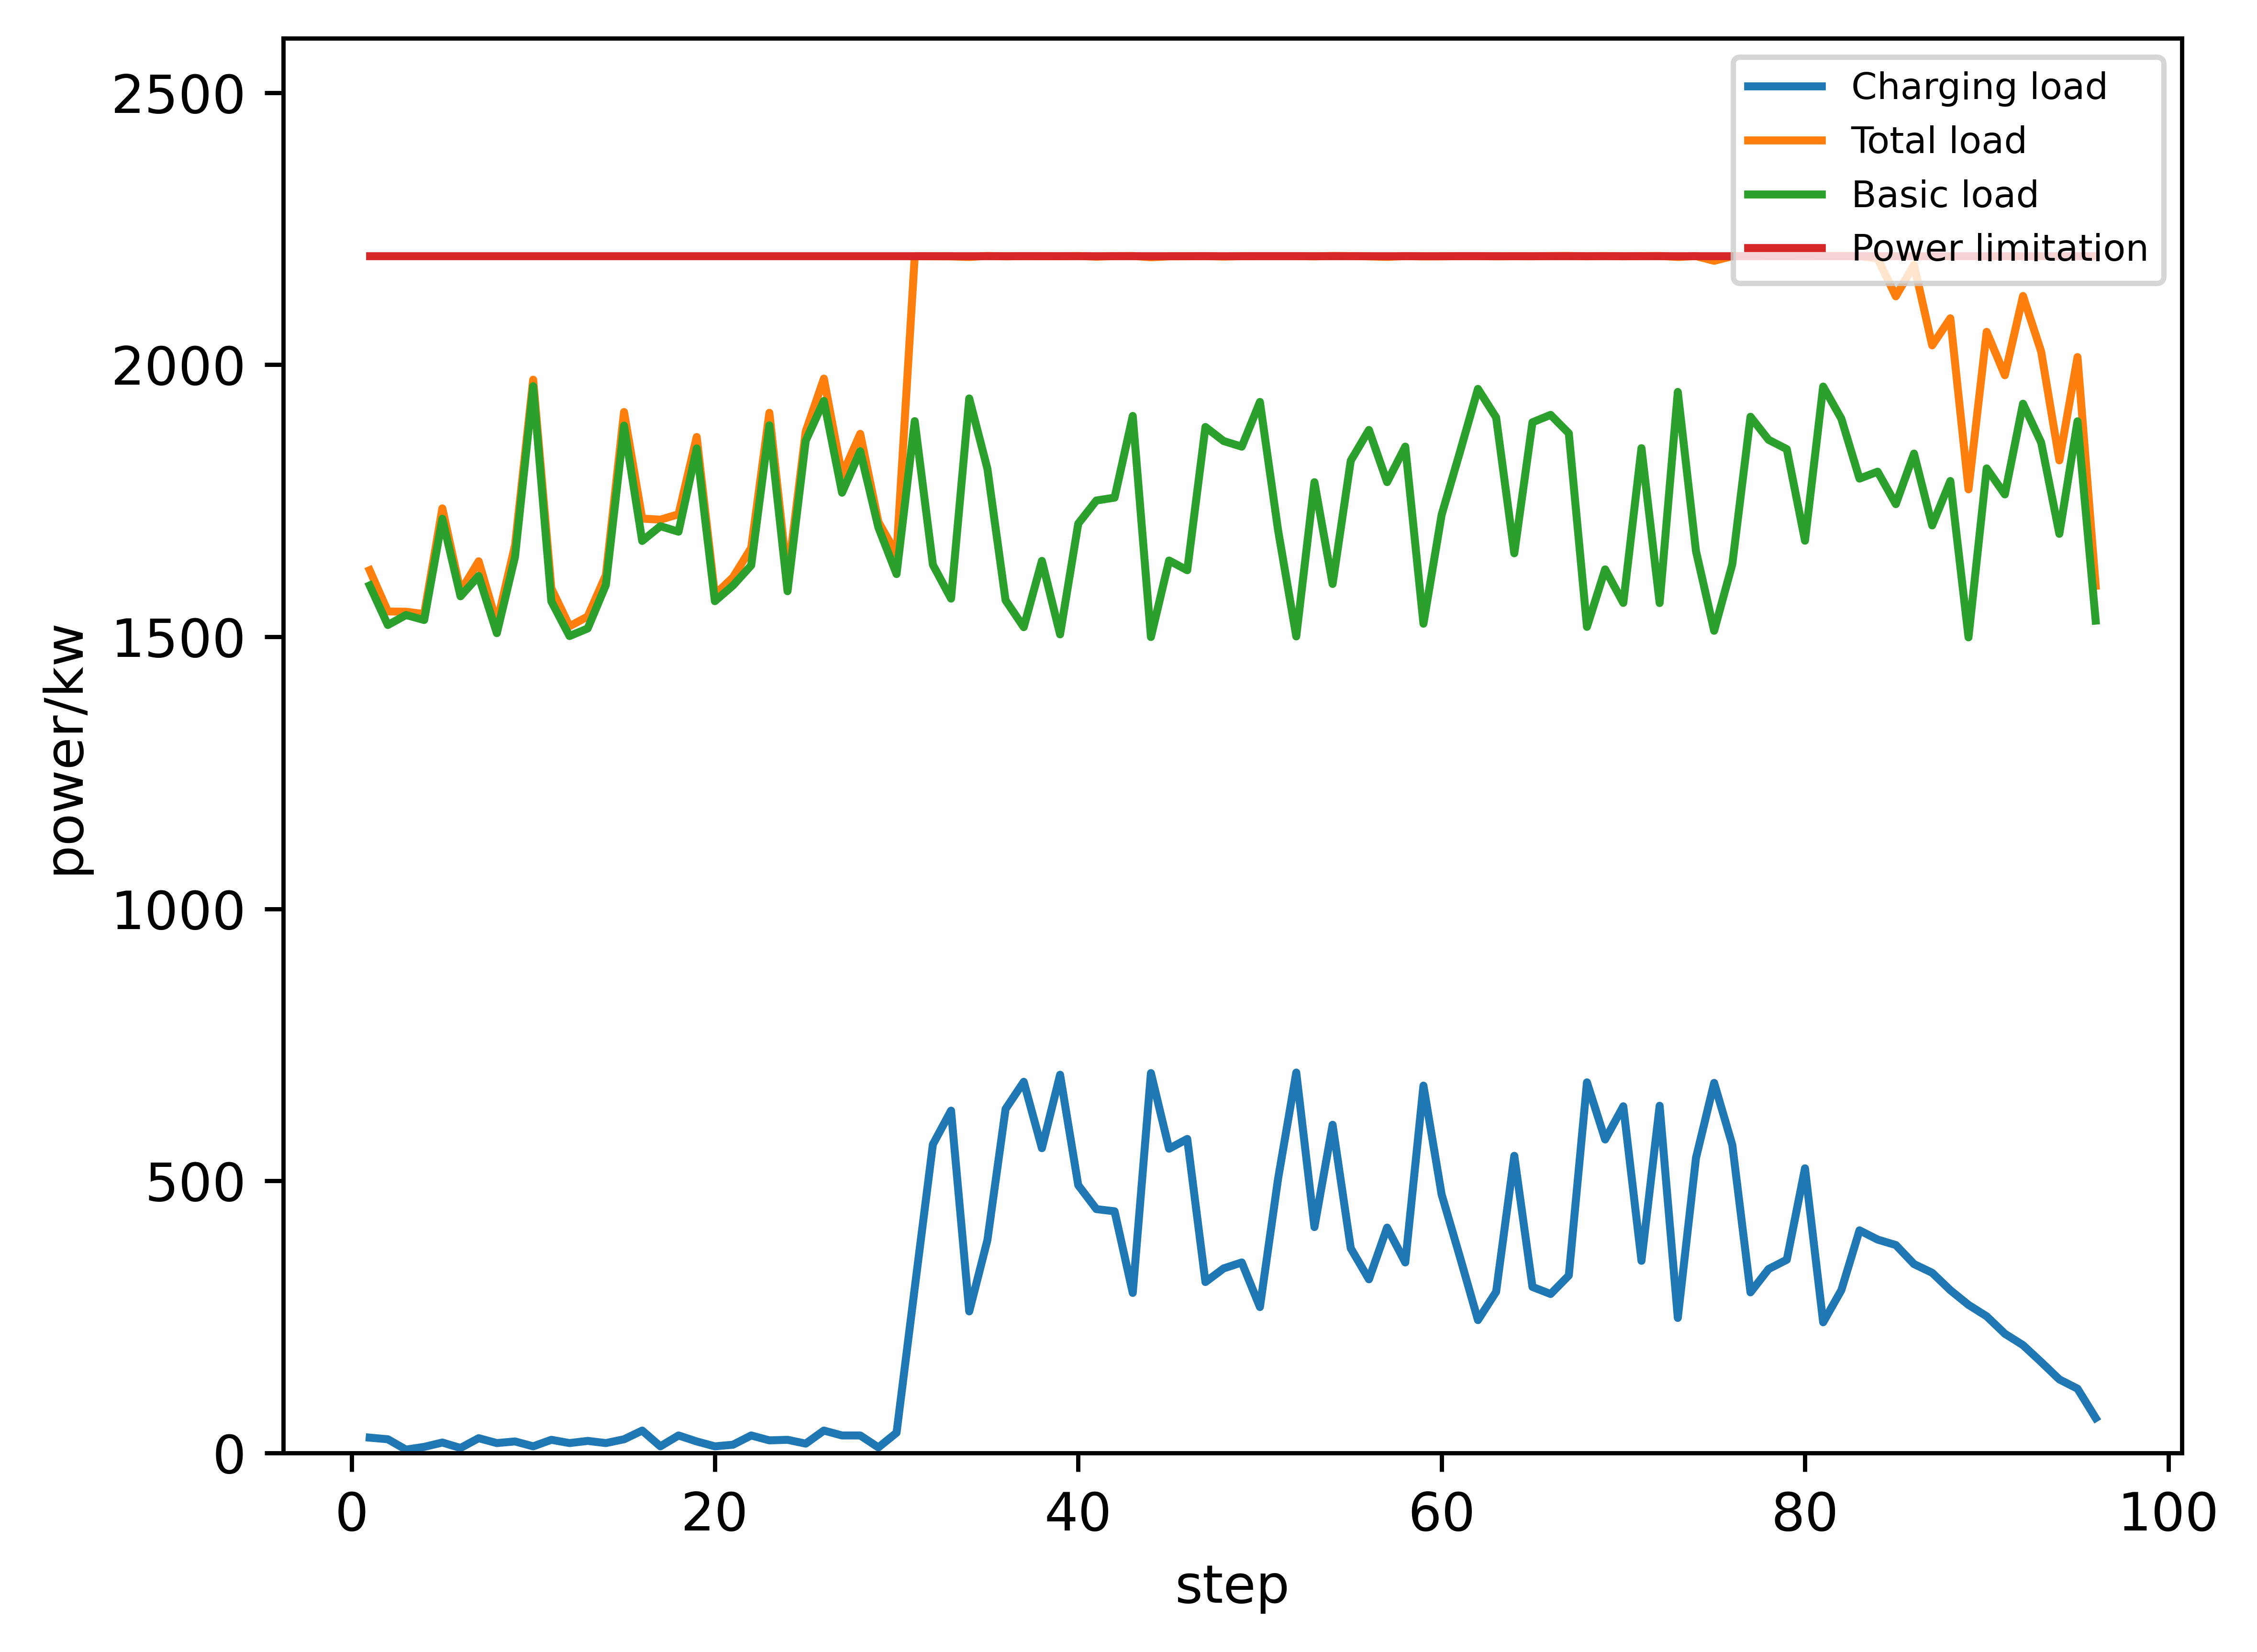

In [99]:
import matplotlib.pyplot as plt
step = np.arange(1, 97)
limit_power = np.full((96), 2200)
plt.figure(dpi=800)
plt.ylim((0,2600))
plt.plot(step, used_power, label = 'Charging load')
plt.plot(step, total_power, label = 'Total load')
plt.plot(step, base_load, label = 'Basic load')
plt.plot(step, limit_power, label = 'Power limitation')
plt.legend(["Charging load","Total load","Basic load","Power limitation"],loc='upper right',fontsize='x-small')
plt.xlabel("step")
plt.ylabel("power/kw")
plt.show()   

Plot three-phase imbalance

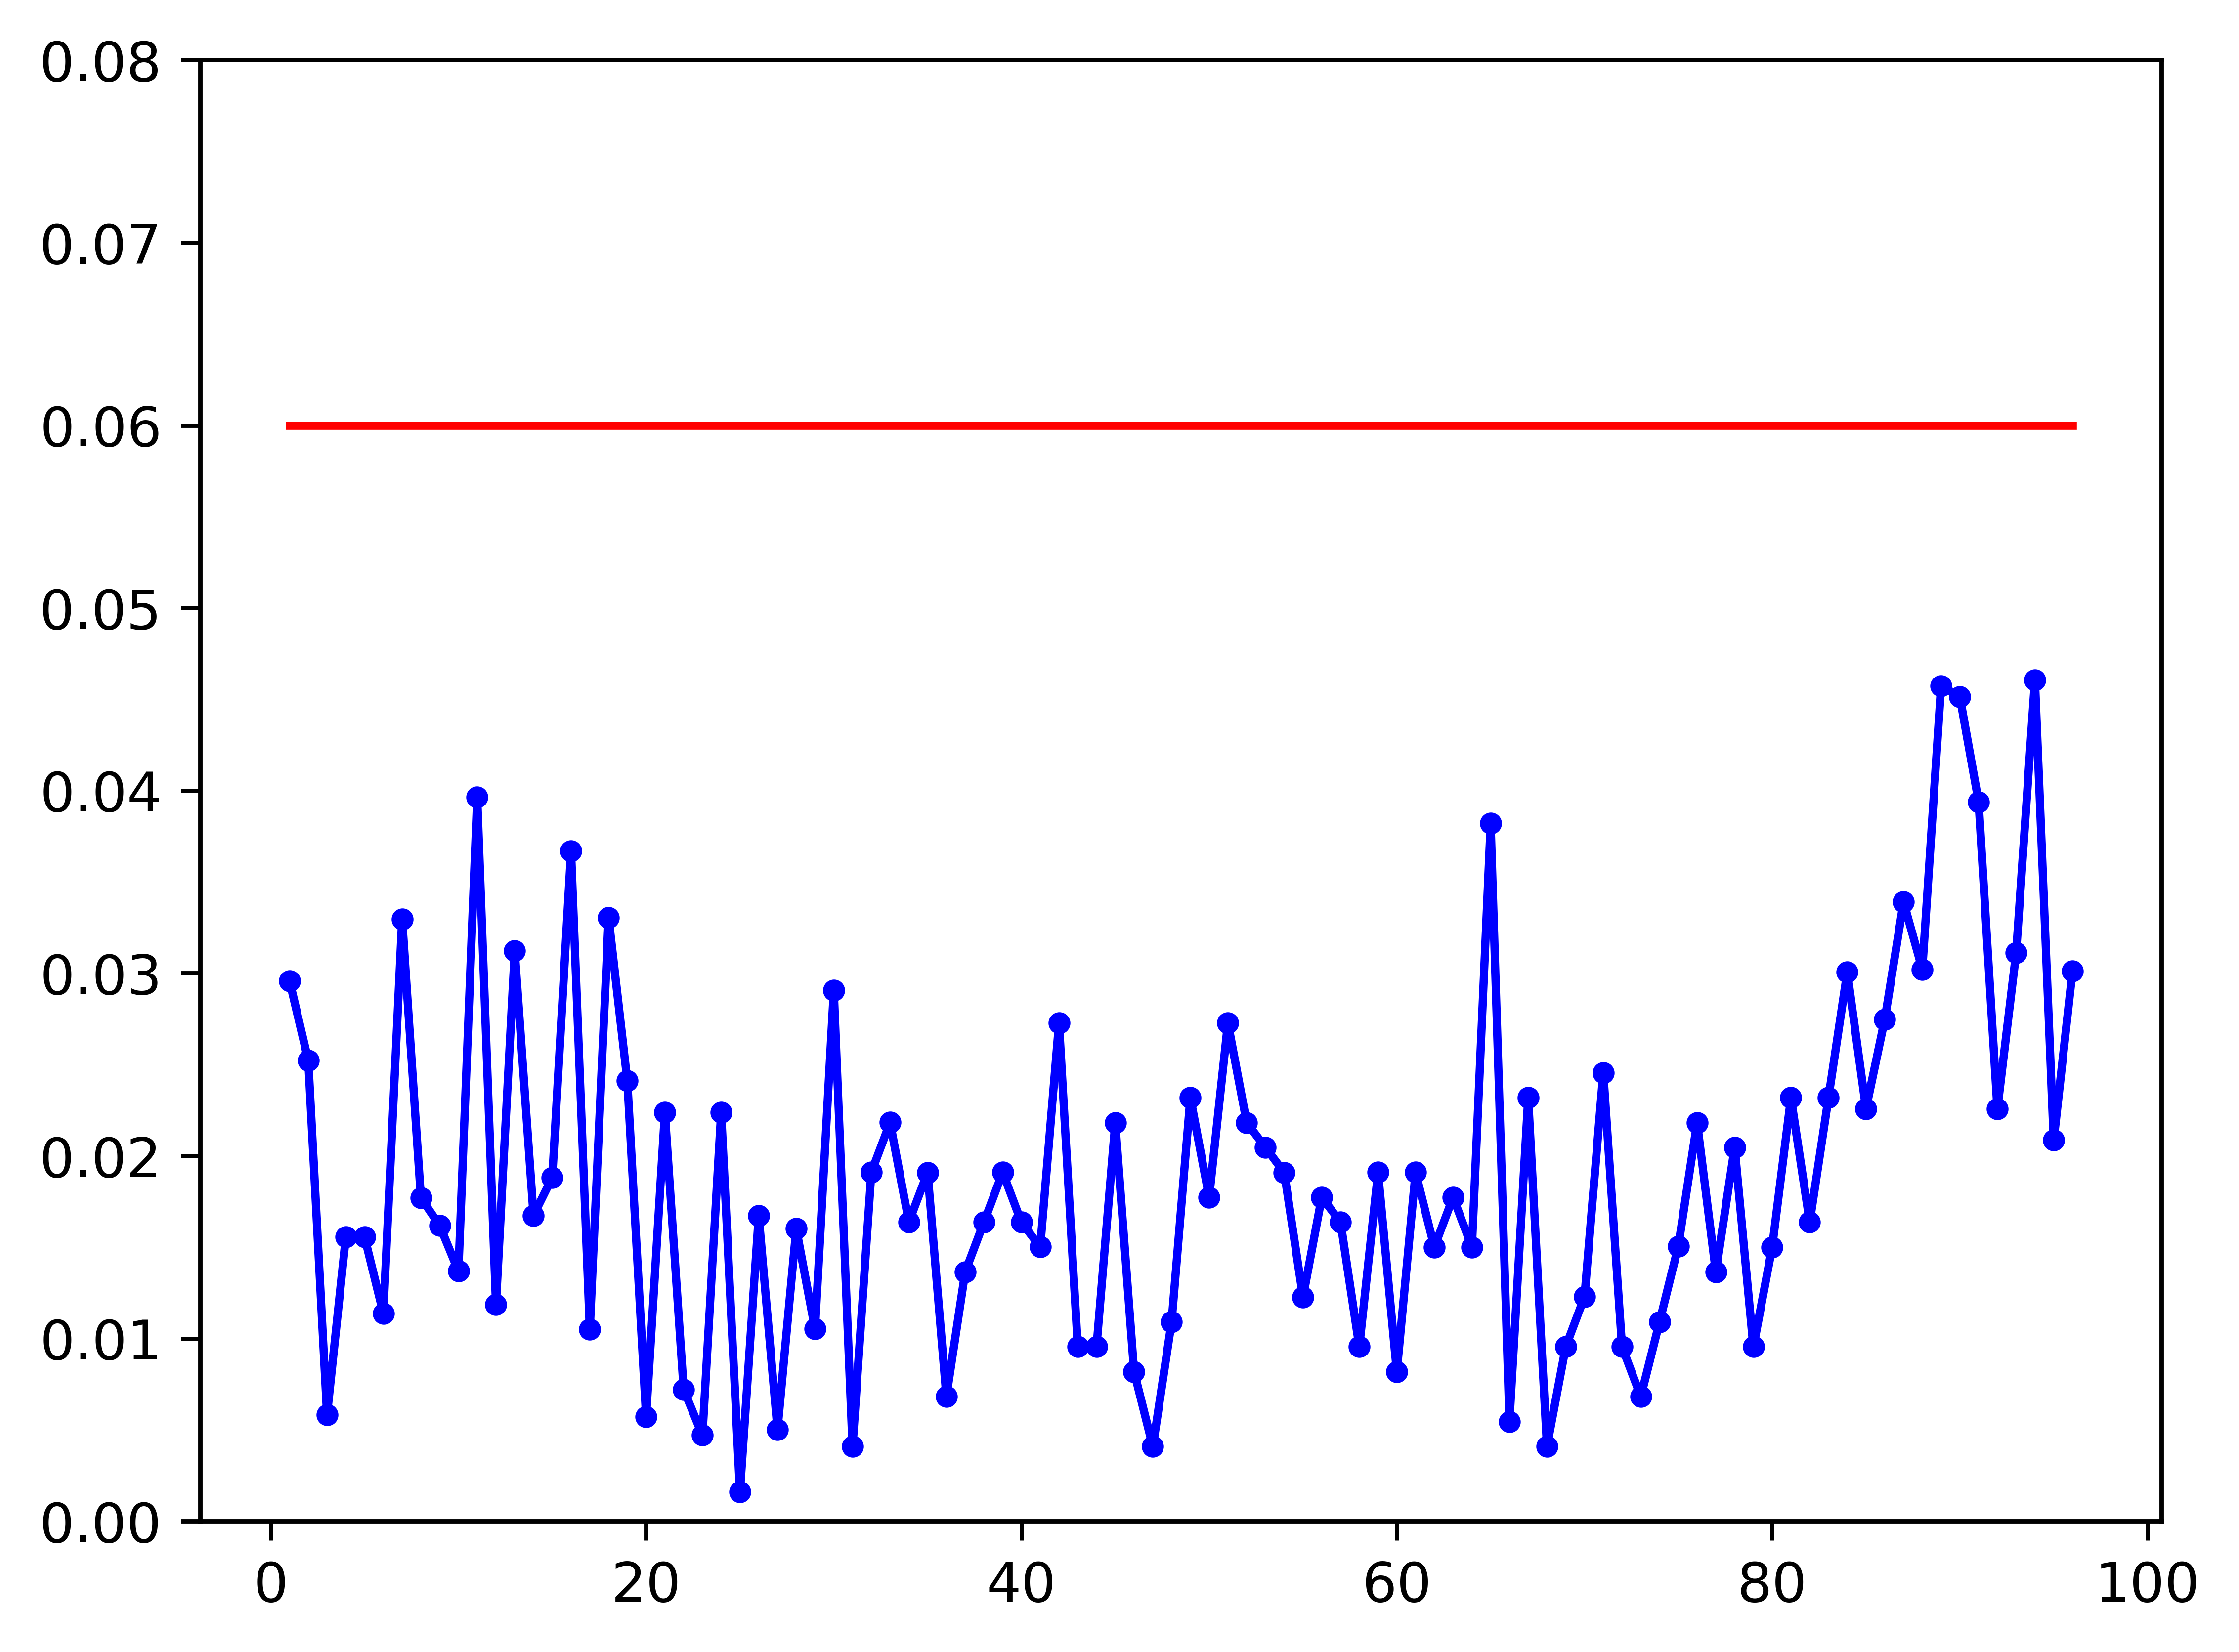

In [100]:
phase_ABC = np.zeros((3, 96))
phases = tasks['Φ']
phase_ABC[0, :] = sum(power_list[k, :] for k in range(len(tasks)) if phases[k] == 'A')
phase_ABC[1, :] = sum(power_list[k, :] for k in range(len(tasks)) if phases[k] == 'B')
phase_ABC[2, :] = sum(power_list[k, :] for k in range(len(tasks)) if phases[k] == 'C')
max_phase = np.max(phase_ABC, axis = 0)
min_phase = np.min(phase_ABC, axis = 0)
imbalance = 3 * (max_phase - min_phase) / total_power
limit_imbalance = np.full((96), 0.06)
plt.figure(dpi=800)
plt.ylim((0,0.08))
plt.plot(step, limit_imbalance, color = 'r', label = 'limit imbalance')
plt.plot(step, imbalance, marker = '.', color = 'b', label = 'imbalance')

Check time constraint

In [101]:
arrival_time_step = tasks['ta']
departure_time_step = tasks['td']

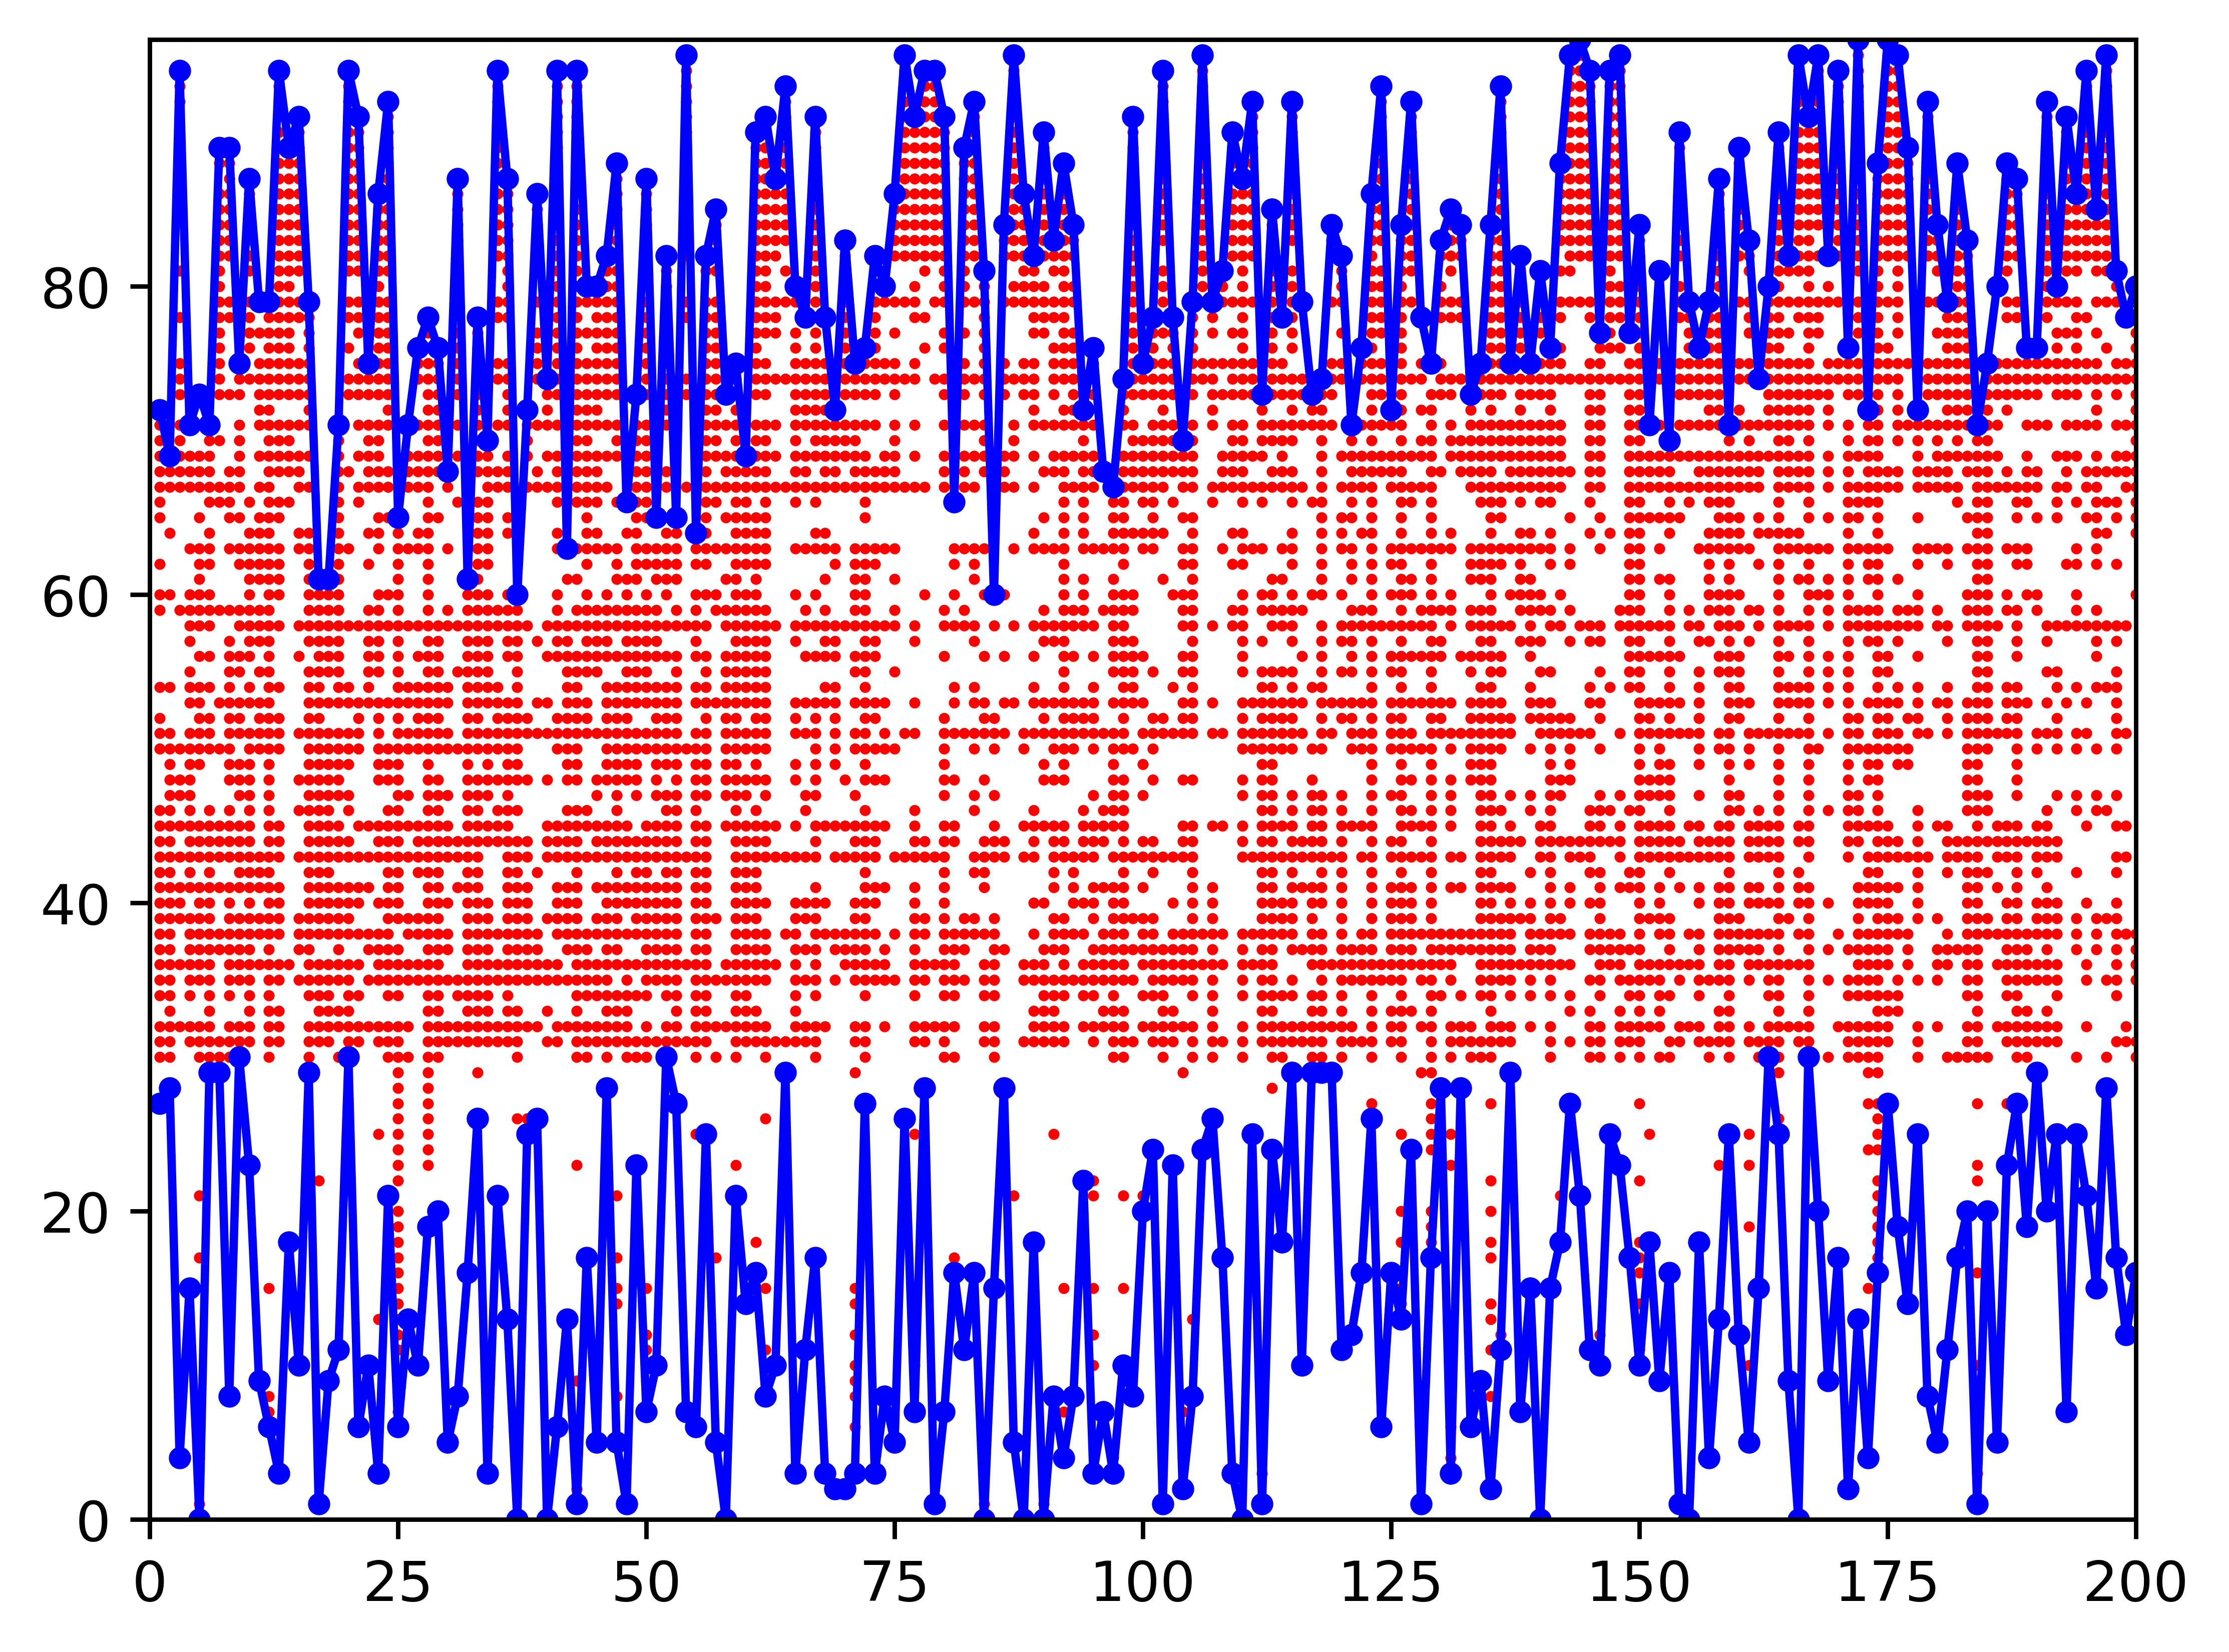

In [102]:
# 获取矩阵中数值为1的元素的坐标
rows, cols = np.where(model_x.T == 1)
cols += 1
# 绘制散点图
plt.figure(dpi=800)
plt.xlim((0, 200))
plt.ylim((0, 96))
plt.scatter(cols, rows, c='red', marker='o', s = 1)

# 画出时间上下限
vehicle = np.arange(1, 201)
plt.plot(vehicle, arrival_time_step, color = 'b', marker = '.')
plt.plot(vehicle, departure_time_step, color = 'b', marker = '.')

In [103]:
col_11 = np.where(model_x.T[:, 3])
print(col_11)
print(arrival_time_step[3])

(array([15, 31, 32, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 53, 54, 55, 57, 58, 59, 60, 63, 67, 68, 69, 71],
      dtype=int64),)
15


Calculate imbalance and cost

In [44]:
def Distinguish_phase():
    # Get a array to distinguish phase A,B,C
    phase_list = np.empty((row), dtype = str)
    for vehicle in range(row):
        # Get three phaseA,B,C load
        if phases[vehicle] == 'A':
            phase_list[vehicle] = 'A'
        elif phases[vehicle] == 'B':
            phase_list[vehicle] = 'B'
        else:
            phase_list[vehicle] = 'C'
    return phase_list

def Calculate_phase(x_values, phase_list):
    # Get phase A,B,C charging power
    power_list = x_values * power
    power_phaseA = np.array(power_list[np.where(phase_list == 'A')])
    power_phaseB = np.array(power_list[np.where(phase_list == 'B')])
    power_phaseC = np.array(power_list[np.where(phase_list == 'C')])
    # PhaseA charging load
    phaseA = np.sum(power_phaseA, axis = 0)
    # PhaseB charging load
    phaseB = np.sum(power_phaseB, axis = 0)
    # PhaseC charging load
    phaseC = np.sum(power_phaseC, axis = 0)
    # Base load for each of the three items
    three_phase = np.vstack((phaseA, phaseB, phaseC)) + phase_base_load

    return three_phase

def Calculate_imbalance(three_phase):
    avg = np.mean(three_phase, axis=0)
    minus = three_phase - avg

    return np.sum(np.square(minus), axis=0)

row = 96
col = 100
ρ1 = np.full((30), 1)
ρ2 = np.full((col - 30), 0.1)
ρ = np.hstack((ρ1 , ρ2))
cost = model_x * ρ * power * 0.25
phase_list = Distinguish_phase()
three_phase = Calculate_phase(model_x, phase_list)
result_phase = Calculate_imbalance(three_phase)
print(np.sum(cost), np.sum(result_phase))

ValueError: operands could not be broadcast together with shapes (100,96) (100,) 

In [104]:
def Distinguish_phase():
    # Get a array to distinguish phase A,B,C
    phase_list = np.empty((row), dtype = str)
    for vehicle in range(row):
        # Get three phaseA,B,C load
        if phases[vehicle] == 'A':
            phase_list[vehicle] = 'A'
        elif phases[vehicle] == 'B':
            phase_list[vehicle] = 'B'
        else:
            phase_list[vehicle] = 'C'
    return phase_list

def Calculate_phase(x_values, phase_list):
    # Get phase A,B,C charging power
    # x_values = np.array([[model.x[j, k] for k in model.cols] for j in model.rows]) #获得model.x的numpy矩阵
    power_list = x_values * power
    power_phaseA = np.array(power_list[np.where(phase_list == 'A')])
    power_phaseB = np.array(power_list[np.where(phase_list == 'B')])
    power_phaseC = np.array(power_list[np.where(phase_list == 'C')])
    # PhaseA charging load
    phaseA = np.sum(power_phaseA, axis = 0)
    # PhaseB charging load
    phaseB = np.sum(power_phaseB, axis = 0)
    # PhaseC charging load
    phaseC = np.sum(power_phaseC, axis = 0)
    # Base load for each of the three items
    three_phase = np.array(np.vstack((phaseA, phaseB, phaseC)) + phase_base_load)

    return three_phase

def Calculate_imbalance(three_phase):
    return np.var(three_phase, axis=0)

row = 100
col = 96
power = np.expand_dims(tasks['P'], axis=1) # 充电功率
ρ1 = np.full((30), 1)
ρ2 = np.full((col - 30), 0.1)
ρ = np.hstack((ρ1 , ρ2)) # 电价
cost = used_power * ρ  * 0.25
phase_list = Distinguish_phase()
three_phase = Calculate_phase(model_x, phase_list)
imbalance = Calculate_imbalance(three_phase)
print(np.sum(cost), np.sum(imbalance))

847.425 3996.2494264472434


Case3 analysis:

In [2]:
jl.seval("import JLD2")
tasks = jl.JLD2.load("./tasks_s1302_n100_py.jld2", "tasks")
phases = jl.JLD2.load("./tasks_s1302_n100_py.jld2", "phases")
data = pd.read_csv("D:/MyProject/Charge_Pyomo/ZhaoYanlong/ev充电/base_load2.csv", header=None)

Read data from csv_file

In [3]:
with open('./data/optimization3.csv', 'r') as csv_file:
    data = csv.DictReader(csv_file)
    print(data.fieldnames)
    model_x = []
    for row in data:
        value = row['Value']
        model_x.append(value)

['\ufeffKey', 'Lower', 'Value', 'Upper', 'Fixed', 'Stale', 'Domain']


In [4]:
model_x = np.array(model_x).reshape((100, 96))
print(model_x)

[['0' '0' '0' ... '0' '0' '0']
 ['0' '0' '0' ... '0' '0' '0']
 ['0' '0' '0' ... '0' '0' '0']
 ...
 ['0' '0' '0' ... '0' '0' '0']
 ['0' '0' '0' ... '0' '0' '0']
 ['0' '0' '0' ... '0' '0' '0']]


In [5]:
base_load_file = pd.read_csv("base_load2.csv", header=None)
base_load = base_load_file.to_numpy()
base_load = base_load.reshape(-1)
restriction_in_power = 2200 - base_load
print(base_load.shape)

(96,)


Plot the circuit load restriction

In [6]:
model_x = model_x.astype(np.float64)
power = np.zeros((100, 1))
for i in range(len(tasks)):
    power[i] = tasks[i].P
power_list = power * model_x
used_power = np.sum(power_list, axis = 0)
total_power = base_load + used_power

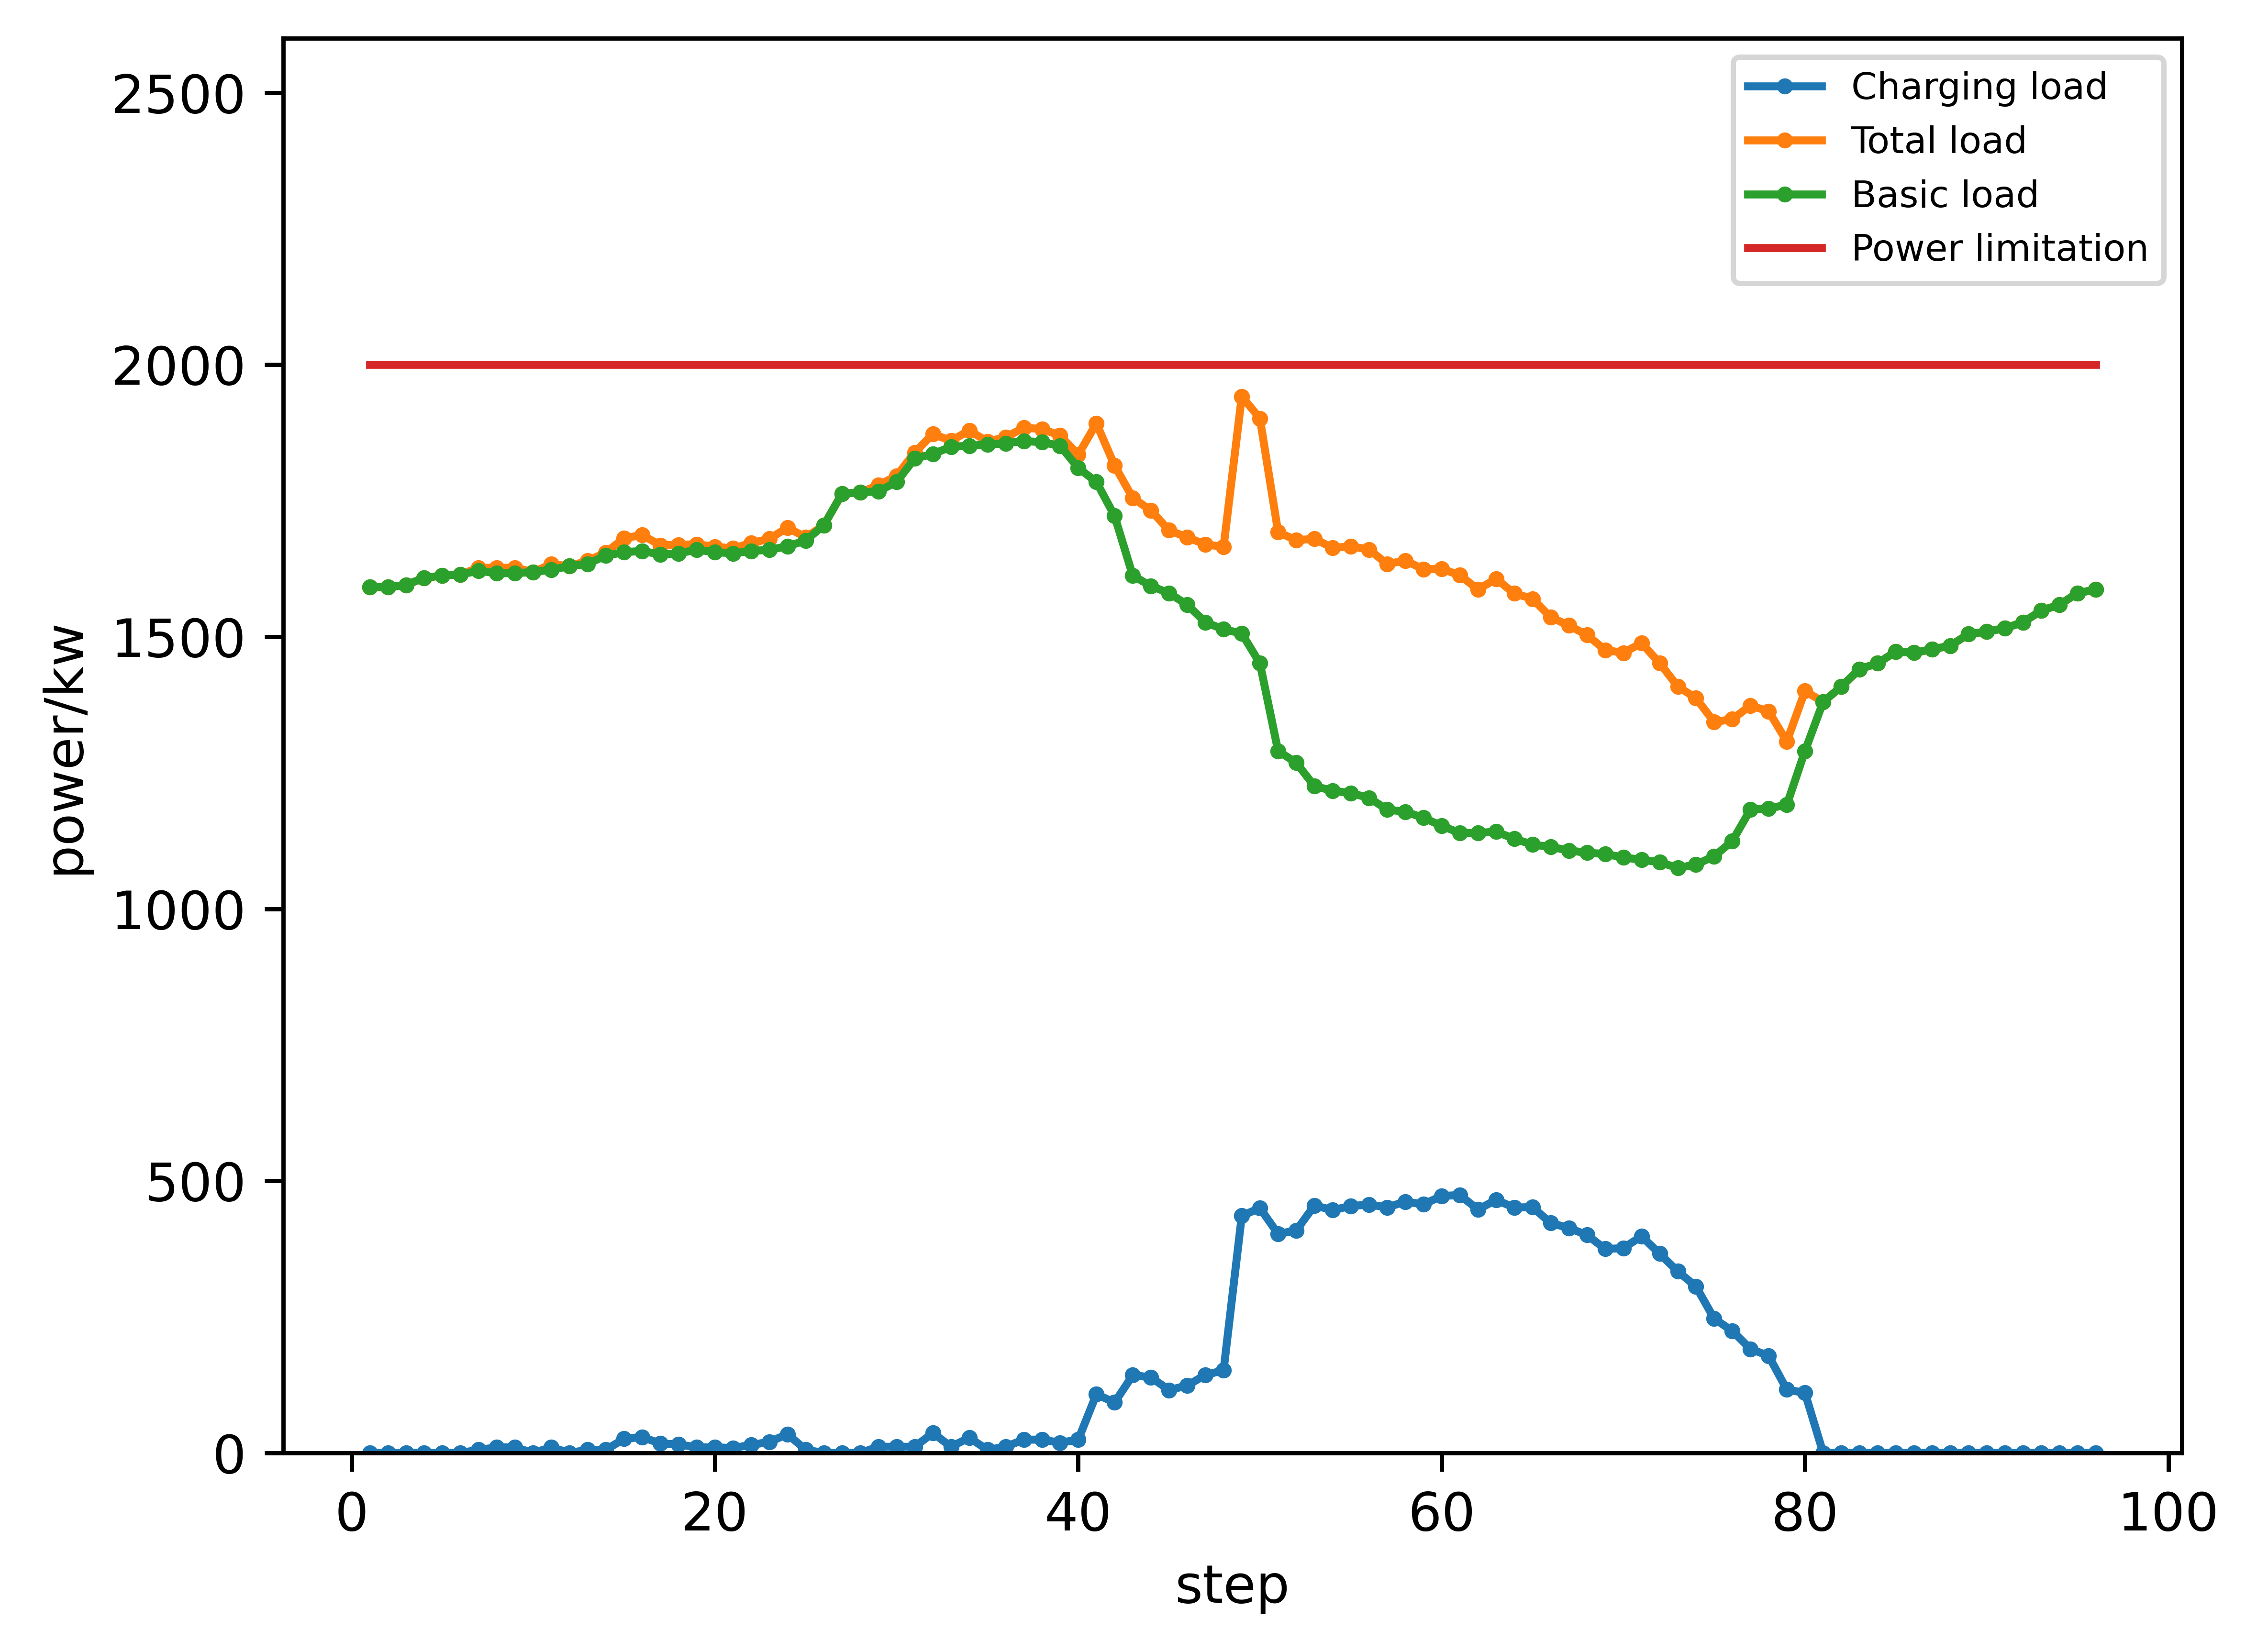

In [14]:
import matplotlib.pyplot as plt
step = np.arange(1, 97)
limit_power = np.full((96), 2000)
plt.figure(dpi=800)
plt.ylim((0,2600))
plt.plot(step, used_power, marker = '.', markersize = 4, label = 'Charging load')
plt.plot(step, total_power, marker = '.', markersize = 4, label = 'Total load')
plt.plot(step, base_load, marker = '.', markersize = 4, label = 'Basic load')
plt.plot(step, limit_power, label = 'Power limitation')
plt.legend(["Charging load","Total load","Basic load","Power limitation"],loc='upper right',fontsize='x-small')
plt.xlabel("step")
plt.ylabel("power/kw")
plt.show()  

Plot three-phase imbalance

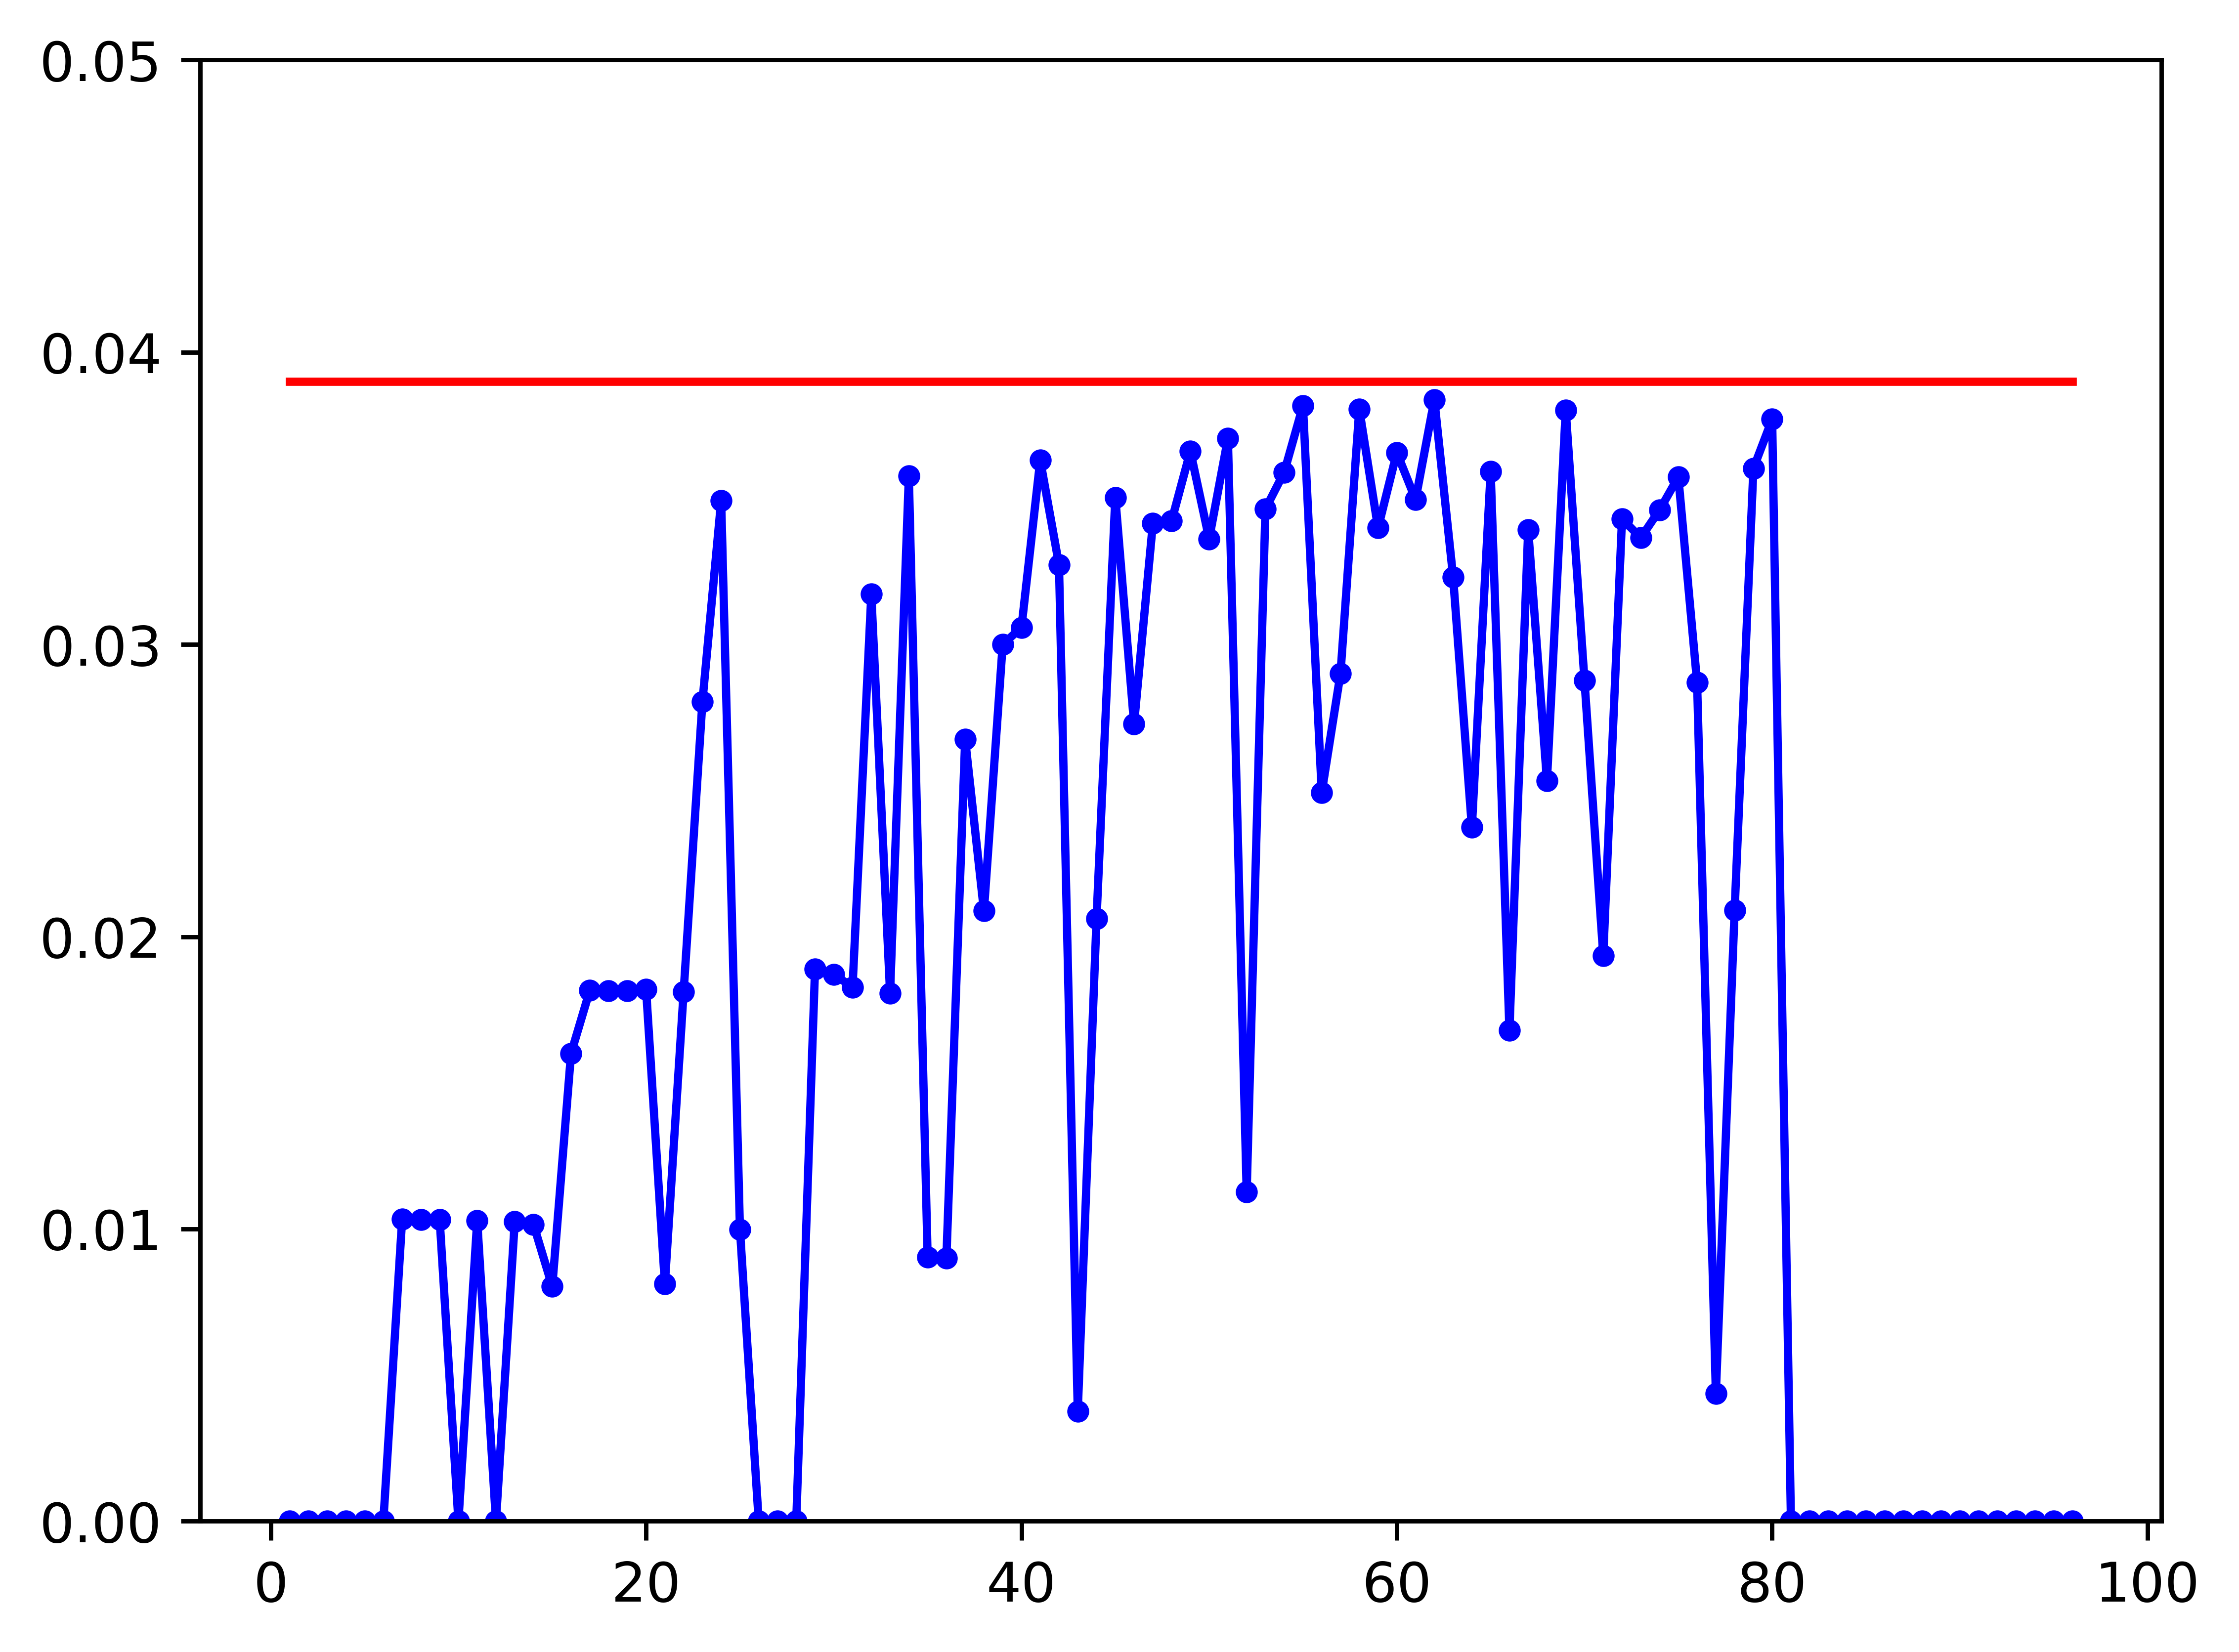

In [9]:
phase_ABC = np.zeros((3, 96))
phase_ABC[0, :] = sum(power_list[k, :] for k in range(len(tasks)) if phases[k] == 'A')
phase_ABC[1, :] = sum(power_list[k, :] for k in range(len(tasks)) if phases[k] == 'B')
phase_ABC[2, :] = sum(power_list[k, :] for k in range(len(tasks)) if phases[k] == 'C')
max_phase = np.max(phase_ABC, axis = 0)
min_phase = np.min(phase_ABC, axis = 0)
imbalance = 3 * (max_phase - min_phase) / total_power
limit_imbalance = np.full((96), 0.039)
plt.figure(dpi=800)
plt.ylim((0,0.05))
plt.plot(step, limit_imbalance, color = 'r', label = 'limit imbalance')
plt.plot(step, imbalance, marker = '.', color = 'b', label = 'imbalance')

Check time restriction

In [15]:
arrival_time_step = np.zeros((100, 1))
departure_time_step = np.zeros((100, 1))
for i in range(len(tasks)):
    arrival_time_step[i] = tasks[i].ta - 332
    departure_time_step[i] = tasks[i].td - 332

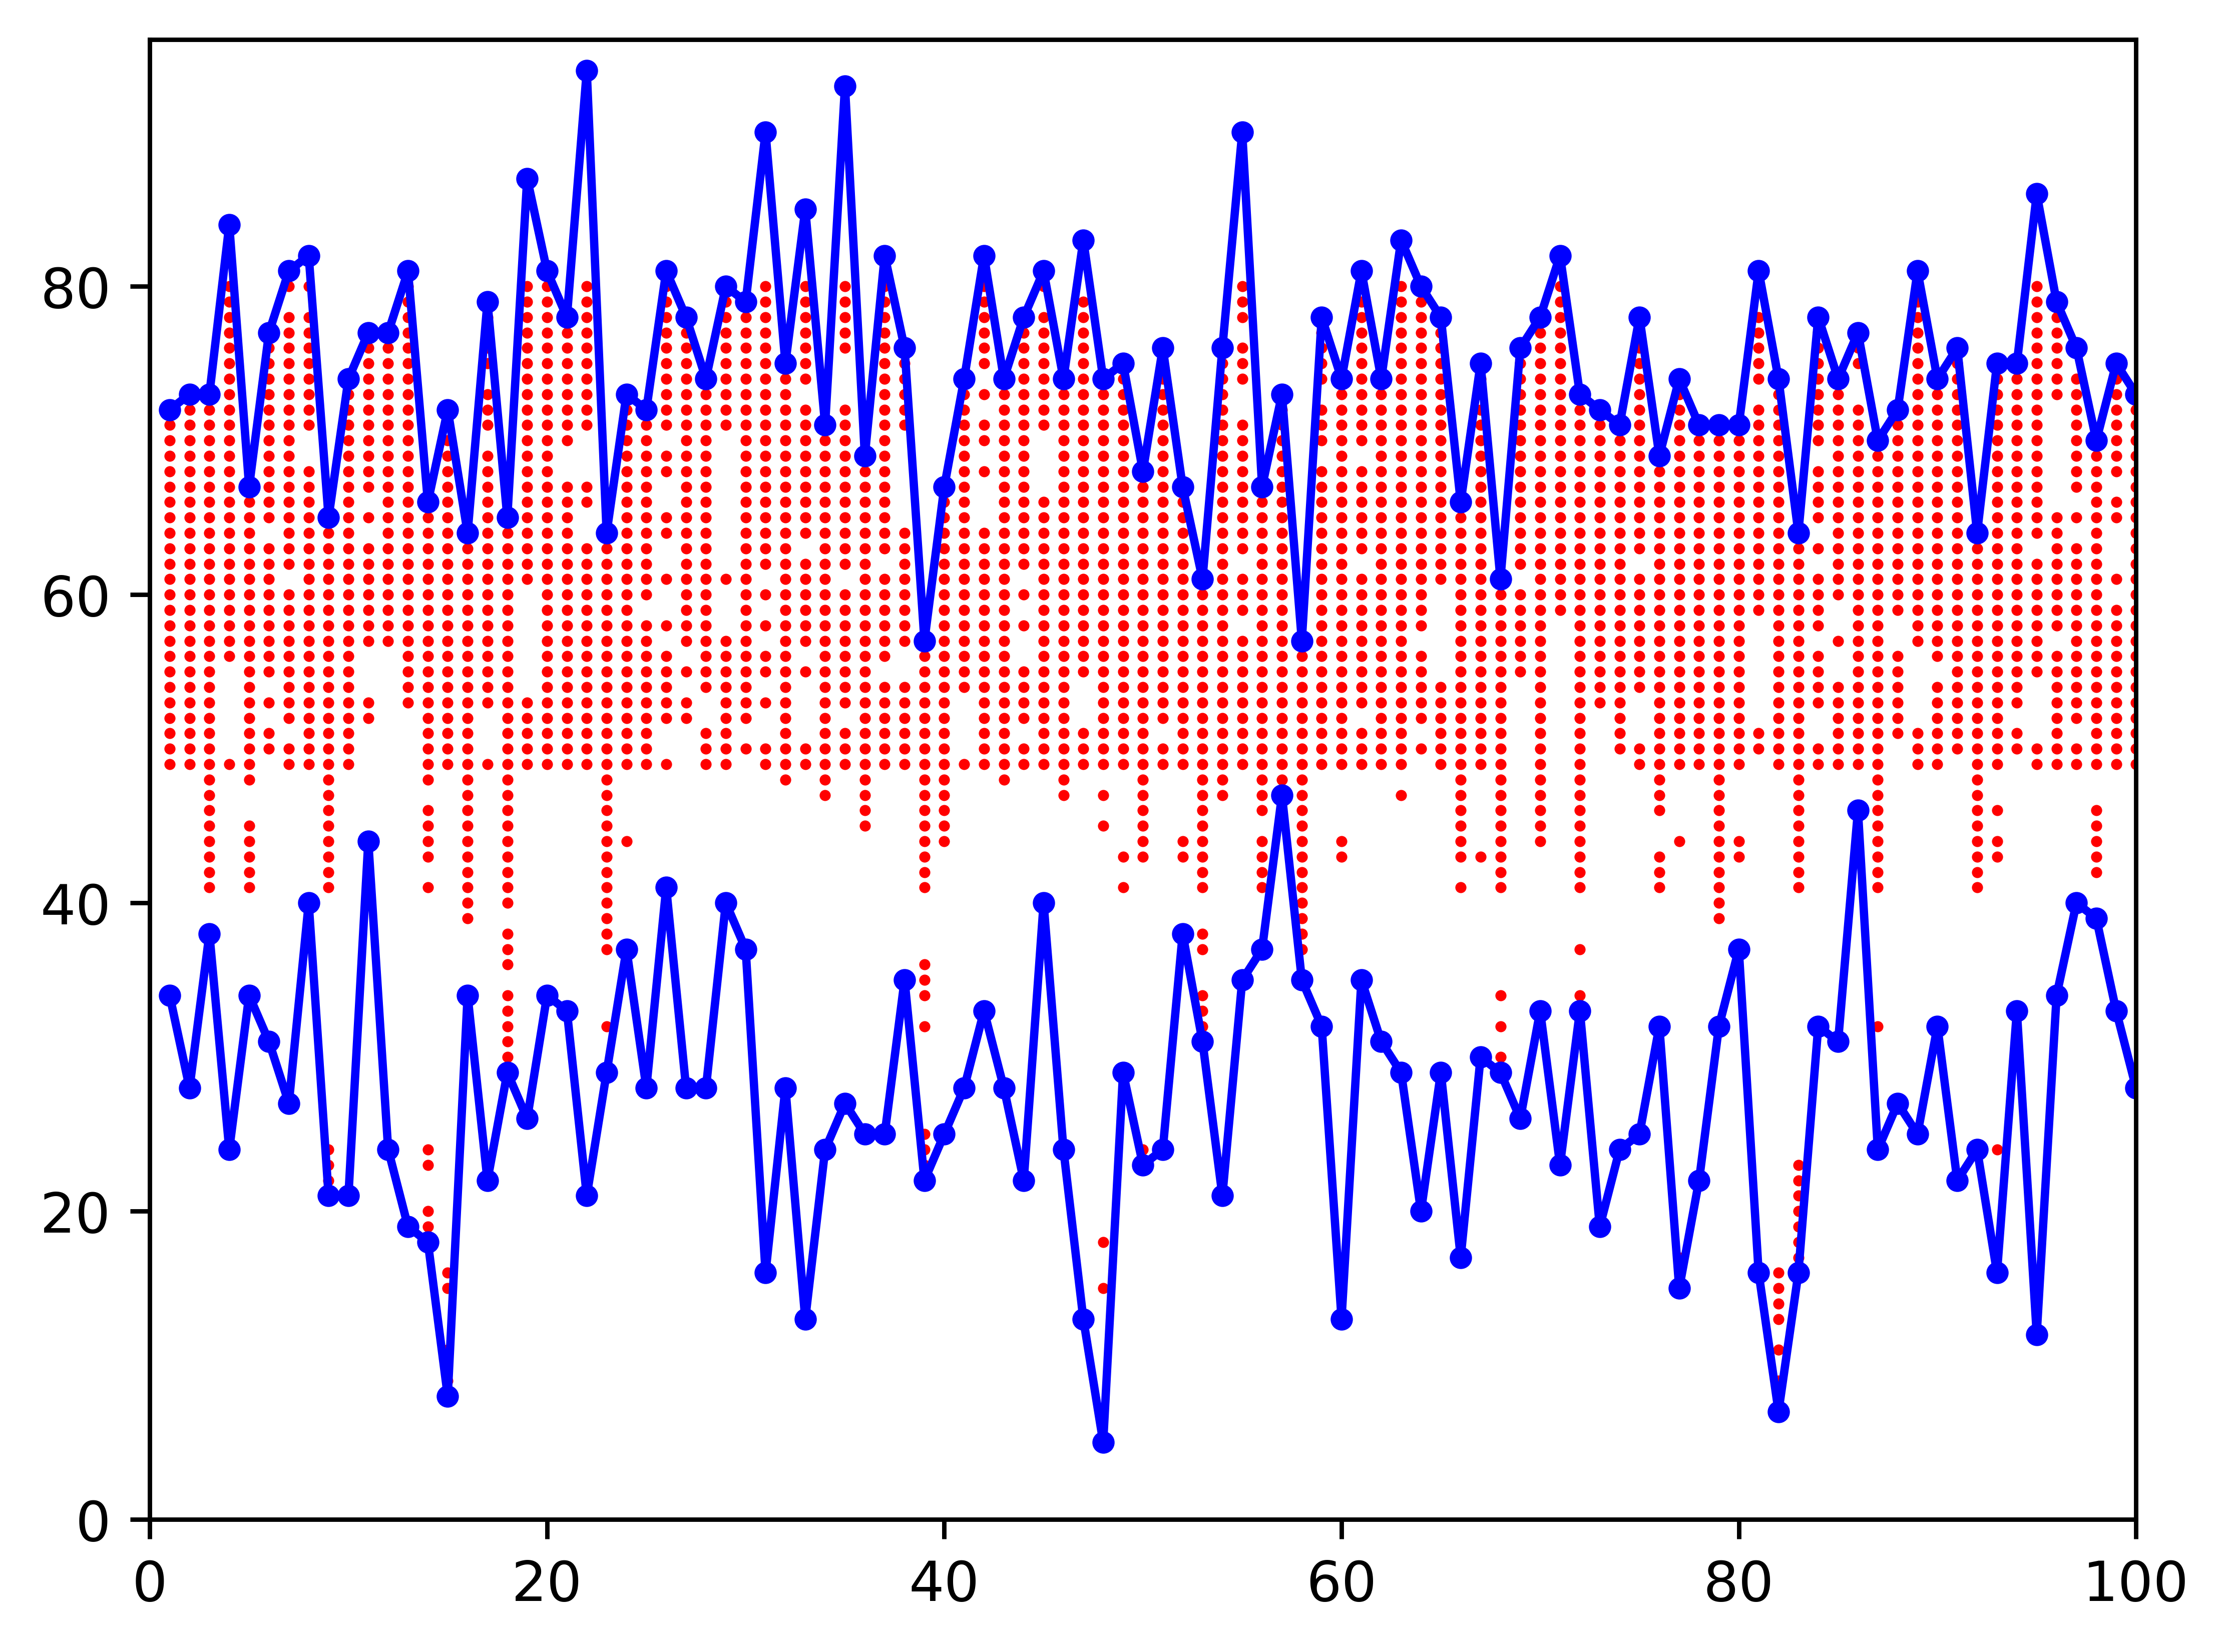

In [16]:
# 获取矩阵中数值为1的元素的坐标
rows, cols = np.where(model_x.T == 1)
cols += 1
# 绘制散点图
plt.figure(dpi=800)
plt.xlim((0, 100))
plt.ylim((0, 96))
plt.scatter(cols, rows, c='red', marker='o', s = 1)

# 画出时间上下限
vehicle = np.arange(1, 101)
plt.plot(vehicle, arrival_time_step, color = 'b', marker = '.')
plt.plot(vehicle, departure_time_step, color = 'b', marker = '.')